# FEATURE TRANSFORMATION

At this stage of the project, different feature transformation techniques will be applied to adapt them to the requirements of the algorithms that will be used during the modelling phase.

As discussed during the project desing stage, three different models will be developed:
1. PD: Probability of default model.
2. EAD: Exposure at default model.
3. LGD: Loss given default model.

In all cases, categorical features have to be transformed into numerical features. Ordinal encoding technique will be applied to ordinal features (`employment_length`, `scoring`). By other hand, `term`, `home_ownership` and `purpose` features will be encoded using one hot encoding. FInally, the rest of the nominal categorical features will be transformed by using target encoding technique. Note that as target encoding process is target-dependent, 3 different transformations must be carried out, one for each of the models to be developed.

Regarding continuous features, given that PD model will be implemented using a logistic regression algorithm (as discussed in previous stages of the project), Gaussian normalisation processes will be applied.

Finally, feature rescaling processes will be applied to transform all features in the dataset to a shared 0-1 scale.

Note that the following features will not be processed as they cannot be used by the models due to this information will not be available at the time models are applied to a new borrower:
- `n_cancellations_12_months`
- `n_months_since_last_derrog`

*Reminder*: In previous stages of the project, the following feature transformation processes were identified:
1. `targets`: Create the targets for probability of default (PD), exposure at default (EAD) and loss given default (LGD) predictive models.
2. `home_ownership`: Group 'ANY', 'OTHER' and 'NONE' categories under the majority category ('MORTGAGE').
3. `purpose`: Group 'wedding', 'renewable_energy' and 'educational' purposes under 'other' category.
4. `p_credit_cards_exceeding_75p`: Discretise into three groups [0,20), [20,80), [80,100].
5. `n_derogations`: Create a binary feature instead.

## IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import strip_accents_unicode

#To increase autocomplete response speed
%config IPCompleter.greedy=True

## DATA IMPORTATION

Project path.

In [2]:
project_path = '../..'

Names of data files.

In [3]:
cat_name = 'cat_result_eda.pickle'
num_name = 'num_result_eda.pickle'

Data importation.

In [4]:
cat = pd.read_pickle(project_path + '/02_Data/03_Work/' + cat_name)
num = pd.read_pickle(project_path + '/02_Data/03_Work/' + num_name)

## DEFINING AND CREATING TARGETS

In this section the target variable for each of probability of default (PD), exposure at default (EAD) and loss given default (LGD) predictive models will be defined and created.

### Target - Probability of Default model (PD)

The purpose of this model will be to predict the probability that a given customer will default.

In the context of this project, a default will be defined as any delay in the payment of loan instalments of more than 90 days.

In [5]:
cat.status.value_counts()

Fully Paid                                             66315
Current                                                54343
Charged Off                                            16446
Late (31-120 days)                                      1325
In Grace Period                                          524
Late (16-30 days)                                        282
Does not meet the credit policy. Status:Fully Paid       118
Does not meet the credit policy. Status:Charged Off       52
Default                                                    2
Name: status, dtype: int64

During the exploratory data analysis phase, it was found that 'Charged off' and 'Does not meet the credit policy. Status:Charged Off' categories had to be considered as default as certain amounts had been recovered in them. Obviously, 'Default' category should also be considered as default.

'Current', 'Fully Paid', 'In Grace Period' and 'Does not meet the credit policy. Status:Fully Paid' categoires will clearly not be considered as non-payments.

Regarding 'Late (31-120 days)' category and due to the selected criterion of considering >90 days = default, a decision should be made whether to include this category as default or not. Given that no additional information is available, it has been decided not to consider this category as default as 66% of its range is below 90 days.

In [6]:
cat['target_pd'] = np.where(cat.status.isin(['Default',
                                             'Charged Off',
                                             'Does not meet the credit policy. Status:Charged Off']),1,0)
cat.drop(columns='status',inplace=True)

### Target - Exposure At Default model (EAD)

The objective of this model is to predict the percentage of the loan that a given borrower has not yet repaid when a default occurs:

\begin{equation*}
\text{target}_{\text{ead}} = \dfrac{\text{Amount to be paid}}{\text{Loan amount}} = \dfrac{\text{Loan amount} - \text{Amortised amount}}{\text{Loan amount}}
\end{equation*}


In [7]:
num['to_be_paid_amount'] = num.loan_amount - num.amortised_amount

In [8]:
num['target_ead'] = num.to_be_paid_amount/num.loan_amount

### Target - Loss Given Default model (LGD)

The objective of this model is to predict the percentage of the principal that will not be possible to recover from a loan that has been defaulted on.

Therefore, the target will be defined as:

\begin{equation*}
\text{target}_{\text{lgd}} = 
    \begin{cases}
      \dfrac{\text{Recovered amount}}{\text{Amount to be paid}} & if \, \text{Amount to be paid} > 1  \\
      0 & if \, \text{Amount to be paid} = 0
    \end{cases} 
\end{equation*}

In [9]:
num['target_lgd'] = 1 - num.recovered_amount/num.to_be_paid_amount
num.target_lgd.fillna(0,inplace=True)

### Checking created targets

`target_pd`:

In [10]:
cat.target_pd.value_counts(normalize=True)

0    0.881642
1    0.118358
Name: target_pd, dtype: float64

`target_ead` and `target_lgd`:

In [11]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139407.0,0.337926,0.369471,-0.000012,0.0,0.130824,0.726128,1.0
target_lgd,139407.0,0.509251,0.490327,-0.275957,0.0,0.851073,1.000000,1.0


The targen values will be limited to the range [0,1]:

In [12]:
num.target_ead.clip(0,1,inplace=True)
num.target_lgd.clip(0,1,inplace=True)

In [13]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139407.0,0.337926,0.369471,0.0,0.0,0.130824,0.726128,1.0
target_lgd,139407.0,0.509274,0.490300,0.0,0.0,0.851073,1.000000,1.0


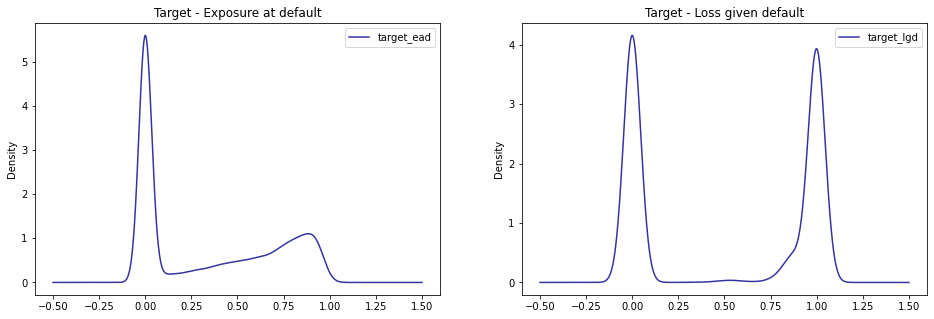

In [14]:
num[['target_ead','target_lgd']].plot(subplots=True ,kind='kde', layout=(1,2), figsize=(16,5), color=['darkblue','darkblue'],
                                      alpha=0.8, title=['Target - Exposure at default','Target - Loss given default']);

## APPLYING TRANSFORMATIONS IDENTIFIED IN PREVIOUS STAGES

In [15]:
cat['home_ownership'] = cat.home_ownership.replace(['ANY','OTHER','NONE'],'MORTGAGE')

cat['purpose'] = cat.purpose.replace(['wedding','renewable_energy','educational'],'other')

cat['p_credit_cards_exceeding_75p_disc'] = pd.cut(num['p_credit_cards_exceeding_75p'], 
                                                  [-float("inf"), 20, 80, float("inf")], 
                                                  labels = ['00_Under_20p','01_20p_80p','02_Over_80p'])

## TRANSFORMATION OF CATEGORICAL FEATURES

### One Hot Encoding

Selecting nominal features to be encoded using OHE:

In [16]:
var_ohe = ['term', 'home_ownership', 'purpose']

Instantiating:

In [17]:
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

Training and applying encoding:

In [18]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

Saving as a dataframe:

In [19]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

### Ordinal Encoding

Selecting nominal features to be encoded using OE:

In [20]:
var_oe = ['employment_length','scoring']

Establishing the order of the categories:

In [21]:
order_employment_length = ['Unknown','< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years',
                           '8 years','9 years','10+ years']

order_scoring = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

Instantiating:

In [22]:
oe = OrdinalEncoder(categories = [order_employment_length,order_scoring],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)

Training and applying:

In [23]:
cat_oe = oe.fit_transform(cat[var_oe])

Saving as a dataframe:

In [24]:
#Adding suffixes to feature names
names_oe = [feature + '_oe' for feature in var_oe]

#Saving as dataframe
cat_oe = pd.DataFrame(cat_oe, columns = names_oe)

### Target Encoding

Selecting nominal features to be encoded using TE:

In [25]:
var_te = ['employment_title', 'income_verification', 'p_credit_cards_exceeding_75p_disc']

Instantiating:

In [26]:
te = TargetEncoder(min_samples_leaf=100, return_df = False)

C:\Users\pedro\miniconda3\envs\pf_riskscoring\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


Training and applying encoding (for each target):

In [27]:
cat_te_pd = te.fit_transform(cat[var_te], y = cat[['target_pd']])
cat_te_ead = te.fit_transform(cat[var_te], y = num[['target_ead']])
cat_te_lgd = te.fit_transform(cat[var_te], y = num[['target_lgd']])

Saving as dataframe:

In [28]:
#Adding suffixes to feature names
names_te_pd = [feature + '_te_pd' for feature in var_te]
names_te_ead = [feature + '_te_ead' for feature in var_te]
names_te_lgd = [feature + '_te_lgd' for feature in var_te]

#Saving as dataframe
cat_te_pd = pd.DataFrame(cat_te_pd, columns = names_te_pd)
cat_te_ead = pd.DataFrame(cat_te_ead, columns = names_te_ead)
cat_te_lgd = pd.DataFrame(cat_te_lgd, columns = names_te_lgd)

## TEXTS

`description`: Basic NLP processes will be applied to test whether useful information can be extracted from this feature. In particular the Tf-idf technique will be used.

Tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

Importing and cleaning stop words list:

In [29]:
stop_words = pd.read_csv(project_path + '/01_Documents/nlp_stop_words.txt', names = ['word'])
stop_words['word_clean'] = stop_words.word.transform(strip_accents_unicode)

Instantiating:

In [30]:
tfidf = TfidfVectorizer(strip_accents = 'unicode',
                        stop_words = stop_words.word_clean.to_list(),
                        max_df = 0.7,
                        min_df = 50,
                        ngram_range = (1,3),
                        max_features = 50)

Training and applying:

In [31]:
chars_to_replace = ['\d+','//','>','br']

description = tfidf.fit_transform(cat.description.transform(strip_accents_unicode) \
                                     .str.replace('|'.join(chars_to_replace), '', regex=True))

C:\Users\pedro\miniconda3\envs\pf_riskscoring\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'daren', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'itse', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


Results:

In [32]:
tfidf.vocabulary_

{'borrower': 1,
 'loan': 28,
 'borrower loan': 5,
 'credit': 16,
 'card': 10,
 'debt': 20,
 'pay': 36,
 'payment': 40,
 'cards': 12,
 'higher': 26,
 'consolidate': 13,
 'payments': 41,
 'month': 33,
 'credit card': 17,
 'card debt': 11,
 'loan pay': 30,
 'credit cards': 19,
 'credit card debt': 18,
 'years': 49,
 'borrower consolidate': 2,
 'consolidate credit': 14,
 'free': 22,
 'pay credit': 37,
 'year': 48,
 'business': 8,
 'bills': 0,
 'rates': 44,
 'work': 47,
 'monthly': 34,
 'paying': 39,
 'rate': 43,
 'time': 46,
 'plan': 42,
 'car': 9,
 'loans': 31,
 'good': 23,
 'job': 27,
 'borrower pay': 6,
 'money': 32,
 'borrower pay credit': 7,
 'loan consolidate': 29,
 'pay credit cards': 38,
 'consolidation': 15,
 'borrower debt': 4,
 'debt consolidation': 21,
 'borrower credit': 3,
 'high': 24,
 'high credit': 25,
 'stable': 45,
 'paid': 35}

**Conclusion**: It does not seem that these terms can generate additional information to that already collected in other features, so `description` feature will not be included in the models.

In [33]:
cat.drop(columns='description',inplace=True)

## TRANSFORMATION OF NUMERICAL FEATURES

### Feature Binarisation

Selecting features to be binarised:

In [34]:
var_bin = ['n_derogations']

Instantiating:

In [35]:
binarizer = Binarizer(threshold=0)

Training and applying:

In [36]:
num_bin = binarizer.fit_transform(num[var_bin])

Saving as a dataframe:

In [37]:
#Adding suffixes to feature names
names_bin = [feature + '_bin' for feature in var_bin]

#Saving as dataframe
num_bin = pd.DataFrame(num_bin,columns = names_bin)

### Feature Normalisation (Gauss)

#### Using Quantile Transformer

Selecting features to be normalised using Quantile Transformer:

In [38]:
var_qt = ['annual_income', 'dti', 'installment', 'interest_rate', 'loan_amount',  
           'n_credit_lines', 'n_mortages', 'revolving_utilization']

Instantiating:

In [39]:
qt = QuantileTransformer(output_distribution='normal')

Training and applying:

In [40]:
num_qt = qt.fit_transform(num[var_qt])

Saving as dataframe:

In [41]:
#Adding suffixes to feature names
names_qt = [feature + '_qt' for feature in var_qt]

#Saving as dataframe
num_qt = pd.DataFrame(num_qt,columns = names_qt)

## FEATURE RESCALATION

Unifying the datasets to be rescaled for each of the models:

In [42]:
# PD model:
df_res_pd = pd.concat([cat_oe,cat_te_pd,num_qt],axis=1)

# EAD model:
df_res_ead = pd.concat([cat_oe,cat_te_ead,num_qt],axis=1)

# LGD model:
df_res_lgd = pd.concat([cat_oe,cat_te_lgd,num_qt],axis=1)

Selecting features to be rescaled using Min-Max for each model

In [43]:
# PD model:
var_mms_pd = df_res_pd.columns

# EAD model:
var_mms_ead = df_res_ead.columns

# LGD model:
var_mms_lgd = df_res_lgd.columns

Instantianting:

In [44]:
mms = MinMaxScaler()

Training and applying:

In [45]:
# PD model:
df_mms_pd = mms.fit_transform(df_res_pd[var_mms_pd])

# EAD model:
df_mms_ead = mms.fit_transform(df_res_ead[var_mms_ead])

# LGD model:
df_mms_lgd = mms.fit_transform(df_res_lgd[var_mms_lgd])

Saving as dataframe:

In [46]:
# Adding suffixes to feature names
    # PD model:
names_mms_pd = [feature + '_mms' for feature in var_mms_pd]
    # EAD model:
names_mms_ead = [feature + '_mms' for feature in var_mms_ead]   
    # LGD model:
names_mms_lgd = [feature + '_mms' for feature in var_mms_lgd]


# Saving as dataframe
    # PD model:
df_mms_pd = pd.DataFrame(df_mms_pd,columns = names_mms_pd)
    # EAD model:
df_mms_ead = pd.DataFrame(df_mms_ead,columns = var_mms_ead)   
    # LGD model:
df_mms_lgd = pd.DataFrame(df_mms_lgd,columns = var_mms_lgd)

## UNIFYING DATASETS

### PD model

Creating a list of dataframes and features to be included for the development of the PD model:

In [47]:
to_include_pd = [cat_ohe, num_bin, df_mms_pd, cat.reset_index()[['client_id','target_pd']]]

Unifying dataframes:

In [48]:
df_pd = pd.concat(to_include_pd,axis=1).set_index('client_id')

### EAD model

Creating a list of dataframes and features to be included for the development of the EAD model:

In [49]:
to_include_ead = [cat_ohe, num_bin, df_mms_ead, num.reset_index()[['client_id','target_ead']]]

Unifying dataframes:

In [50]:
df_ead = pd.concat(to_include_ead,axis=1).set_index('client_id')

### LGD model

Creating a list of dataframes and features to be included for the development of the LGD model:

In [51]:
to_include_lgd = [cat_ohe, num_bin, df_mms_lgd, num.reset_index()[['client_id','target_lgd']]]

Unifying dataframes:

In [52]:
df_lgd = pd.concat(to_include_lgd,axis=1).set_index('client_id')

## SAVING DATASETS AFTER DATA TRANSFORMATION

df_pd, df_ead and df_lgd dataframes will be saved once data transformation procedures have been applied.

In pickle format so as not to lose metadata modifications.

### Defining dataset names

In [53]:
path_df_input_pd = project_path + '/02_Data/03_Work/' + 'df_input_pd.pickle'
path_df_input_ead = project_path + '/02_Data/03_Work/' + 'df_input_ead.pickle'
path_df_input_lgd = project_path + '/02_Data/03_Work/' + 'df_input_lgd.pickle'

### Saving datasets

In [54]:
df_pd.to_pickle(path_df_input_pd)
df_ead.to_pickle(path_df_input_ead)
df_lgd.to_pickle(path_df_input_lgd)